In [1]:
import os
import torch
import numpy as np
import pandas as pd
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Define dataset directory
class_mapping = {"dry": 0, "normal": 1, "oily": 2}
rev_class_mapping = {v: k for k, v in class_mapping.items()}

def build_dataframe(base_path):
    data_records = {"filepaths": [], "labels": []}
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        for img_file in os.listdir(category_path):
            data_records["filepaths"].append(os.path.join(category_path, img_file))
            data_records["labels"].append(class_mapping[category])
    return pd.DataFrame(data_records)

In [3]:
# Construct dataset
dataset_df = pd.concat([
    build_dataframe("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train"),
    build_dataframe("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid"),
    build_dataframe("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")
])

In [4]:
# Dataset class
class SkinTypeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:

# config(tried with different hyperparameters)
num_epochs = 30
step_size = 7
lr_decay = 0.2
batch_size = 32
num_classes = 3
image_size = 224
lr = 0.001

In [6]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split dataset
train_data, test_data = train_test_split(dataset_df, test_size=0.2, stratify=dataset_df.labels, random_state=42)
train_dataset = SkinTypeDataset(train_data, transform=data_transforms)
test_dataset = SkinTypeDataset(test_data, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

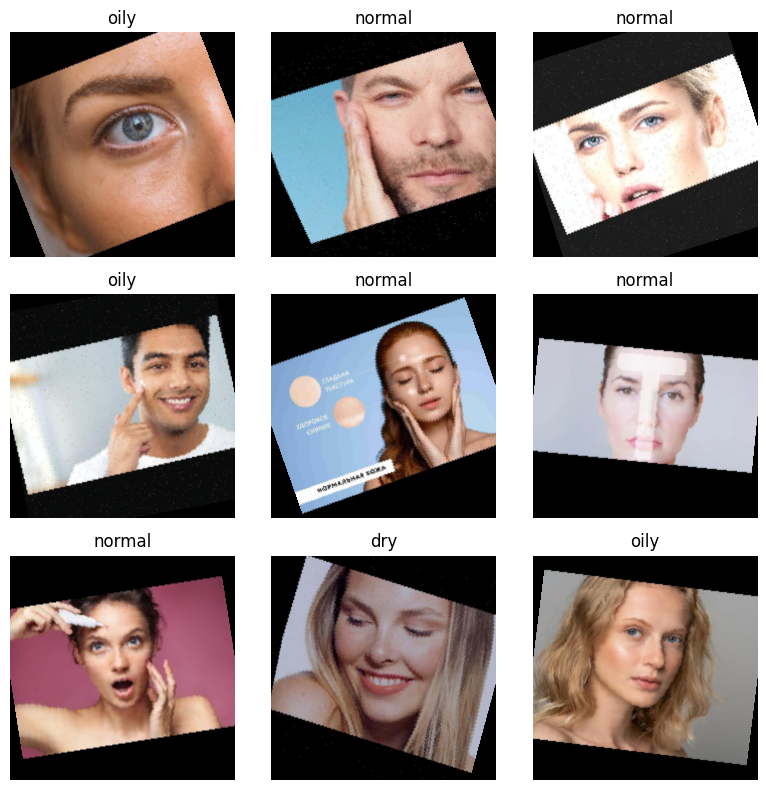

In [7]:
# Visualize sample images from training set
def visualize_samples(dataset, num_samples=9):
    plt.figure(figsize=(8, 8))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(rev_class_mapping[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

In [8]:
# Accuracy and loss history
history = {}
test_accuracies = {}

# Training function
def train_and_evaluate(model, train_loader, test_loader, model_name, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=lr_decay)
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    best_val_acc = 0.0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        correct = total = 0
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        model.eval()
        correct = total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                val_loss += loss.item()
        val_acc = correct / total
        val_loss /= len(test_loader)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"{model_name} | Epoch {epoch+1}/{num_epochs} => Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = deepcopy(model)

        scheduler.step()

    # Save best model as .pt file
    save_path = f"best_{model_name}.pt"
    torch.save(best_model, save_path)
    print(f"Saved best model: {save_path} with Val Accuracy: {best_val_acc:.4f}")

    history[model_name] = {
        "train": train_accuracies,
        "val": val_accuracies,
        "train_loss": train_losses,
        "val_loss": val_losses
    }

    # Final test set evaluation
    best_model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            _, preds = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=list(class_mapping.keys())))

    test_acc = sum([p == t for p, t in zip(y_pred, y_true)]) / len(y_true)
    test_accuracies[model_name] = test_acc

    return best_model

In [9]:
# Train multiple models
model_configs = [
    ("mobilenetv2", models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)),
    ("resnet50", models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)),
    ("efficientnet_b0", models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1))
]

for name, model in model_configs:
    if name == "mobilenetv2" or name == "efficientnet_b0":
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "resnet50":
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    train_and_evaluate(model, train_loader, test_loader, model_name=name, learning_rate=lr)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 234MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 239MB/s]


mobilenetv2 | Epoch 1/30 => Train Acc: 0.3979, Val Acc: 0.4422, Train Loss: 1.1086, Val Loss: 1.0408
mobilenetv2 | Epoch 2/30 => Train Acc: 0.4839, Val Acc: 0.4374, Train Loss: 1.0329, Val Loss: 1.1215
mobilenetv2 | Epoch 3/30 => Train Acc: 0.5268, Val Acc: 0.4532, Train Loss: 0.9780, Val Loss: 1.0300
mobilenetv2 | Epoch 4/30 => Train Acc: 0.5470, Val Acc: 0.5151, Train Loss: 0.9326, Val Loss: 1.1284
mobilenetv2 | Epoch 5/30 => Train Acc: 0.6041, Val Acc: 0.5293, Train Loss: 0.8832, Val Loss: 1.0116
mobilenetv2 | Epoch 6/30 => Train Acc: 0.6117, Val Acc: 0.5547, Train Loss: 0.8612, Val Loss: 0.9245
mobilenetv2 | Epoch 7/30 => Train Acc: 0.6569, Val Acc: 0.5420, Train Loss: 0.7950, Val Loss: 1.0413
mobilenetv2 | Epoch 8/30 => Train Acc: 0.7644, Val Acc: 0.6830, Train Loss: 0.5836, Val Loss: 0.7650
mobilenetv2 | Epoch 9/30 => Train Acc: 0.8227, Val Acc: 0.7401, Train Loss: 0.4632, Val Loss: 0.6896
mobilenetv2 | Epoch 10/30 => Train Acc: 0.8576, Val Acc: 0.7544, Train Loss: 0.3811, Val Lo

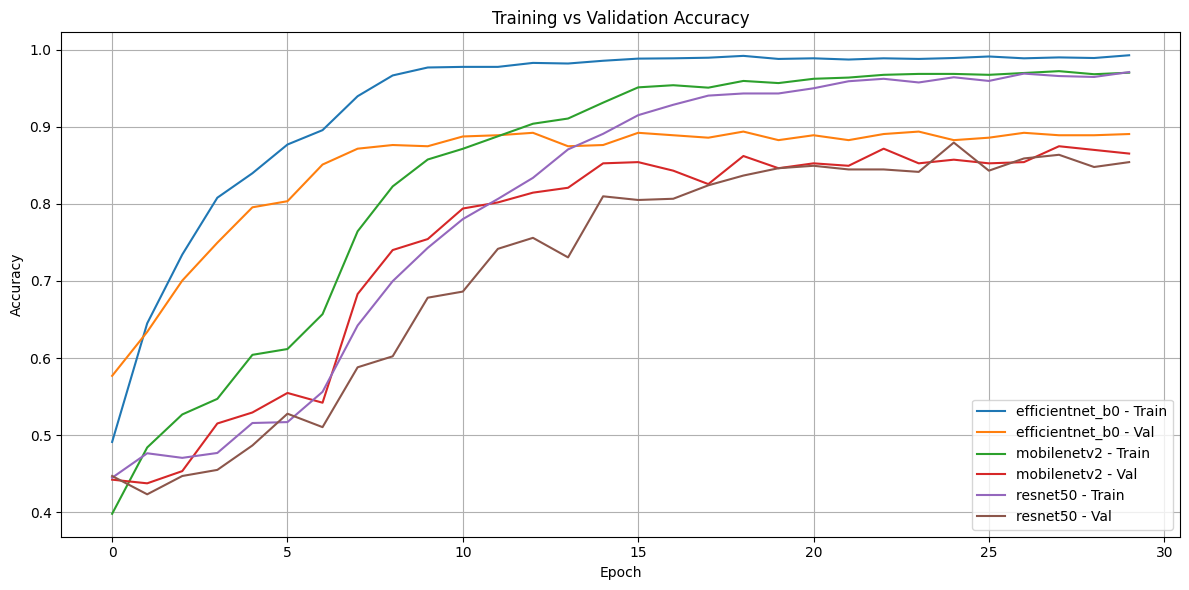

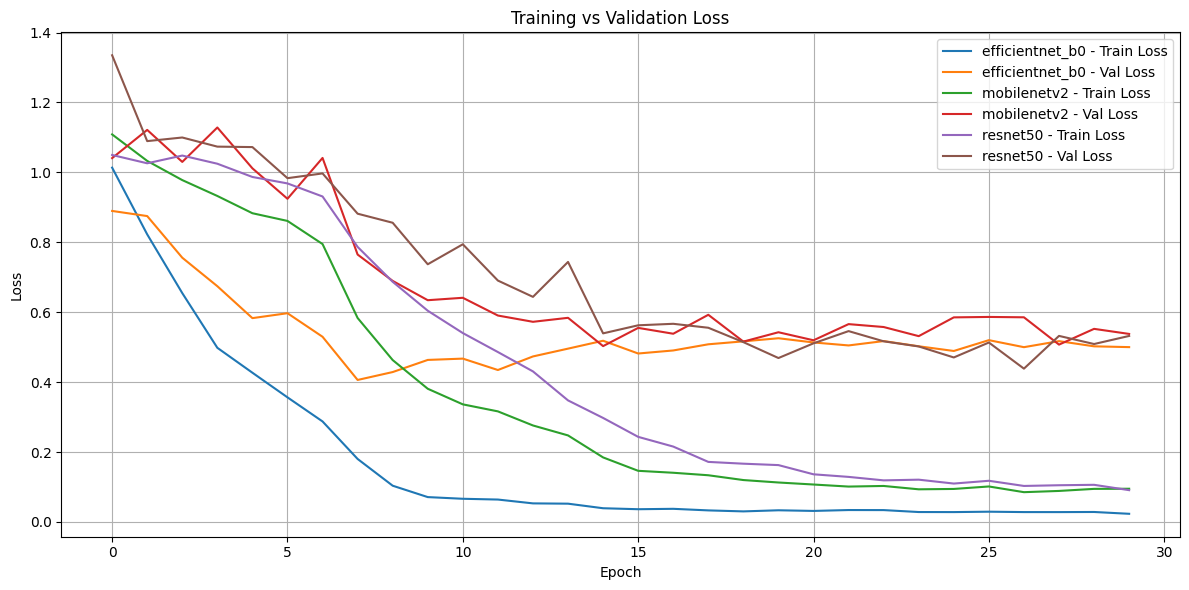

In [11]:
# Accuracy plot
plt.figure(figsize=(12, 6))
for model_name in sorted(history):
    plt.plot(history[model_name]["train"], label=f"{model_name} - Train")
    plt.plot(history[model_name]["val"], label=f"{model_name} - Val")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_comparison.png")
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
for model_name in sorted(history):
    plt.plot(history[model_name]["train_loss"], label=f"{model_name} - Train Loss")
    plt.plot(history[model_name]["val_loss"], label=f"{model_name} - Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_comparison.png")
plt.show()

In [18]:

# Test accuracy comparison
print("\nTest Accuracy Comparison:")
for model_name, acc in test_accuracies.items():
    print(f"{model_name}: {acc:.4f}")


Test Accuracy Comparison:
mobilenetv2: 0.8574
resnet50: 0.8526
efficientnet_b0: 0.8843


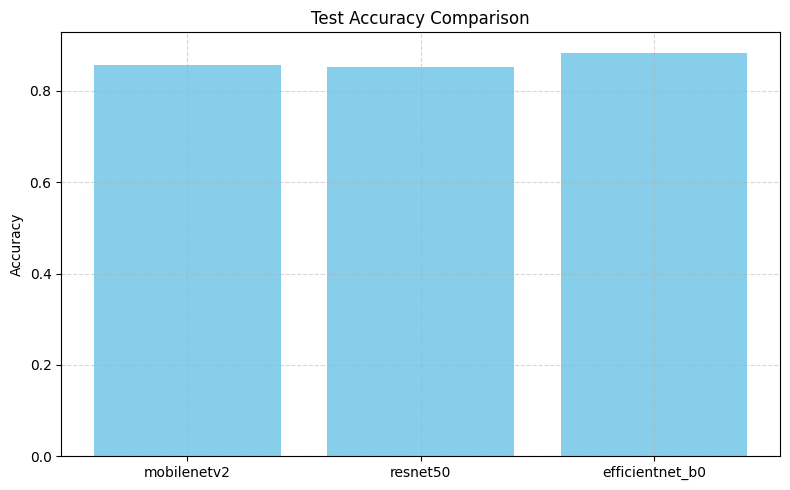

In [19]:
plt.figure(figsize=(8, 5))
model_names = list(test_accuracies.keys())
accuracies = [test_accuracies[m] for m in model_names]
plt.bar(model_names, accuracies, color='skyblue')
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("test_accuracy_comparison.png")
plt.show()
